# High Irradiance Response (HIRES)

The HIRES problem is a common stiff differential equation.

In [1]:
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.integrate
from diffeqzoo import backend, ivps
from jax import config

from probdiffeq.impl import impl
from probdiffeq.util.doc_util import benchmark, info, notebook, workprecision
from probdiffeq.solvers import calibrated
from probdiffeq.solvers.strategies.components import priors, corrections
from probdiffeq.solvers.strategies import filters

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

# Which version of the softwares are we using?
info.print_info()


ProbDiffEq version:
	0.1.5.dev125
Diffrax version:
	0.3.1
SciPy version:
	1.10.1

Most recent ProbDiffEq commit:
	b'0fee95\n'

jax:    0.4.16
jaxlib: 0.4.16
numpy:  1.24.3
python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


I0000 00:00:1695989114.195449  254318 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
impl.select("dense", ode_shape=(2,))

In [4]:
f, u0, (t0, t1), f_args = ivps.hires()


@jax.jit
def vf(x, *, t):
    return f(x, *f_args)


problem = benchmark.FirstOrderIVP(vector_field=vf, initial_values=(u0,), t0=t0, t1=t1)

problem_scipy = problem.to_scipy(t_eval=[t0, t1])
print(problem_scipy)
problem_diffrax = problem.to_diffrax()
problems = {
    "probdiffeq": problem,
    "diffrax": problem_diffrax,
    "scipy": problem_scipy,
}

In [5]:
# Compute a reference solution
scipy_solution = scipy.integrate.solve_ivp(
    *problem_scipy.args,
    atol=1e-13,
    rtol=1e-13,
    method="BDF",
)

# Select all remaining problem parameters
rtols = 0.1 ** jnp.arange(1.0, 9.0, step=1.0)
atols = 1e-3 * rtols
num_repeats = 10
error_fn = benchmark.relative_rmse(solution=scipy_solution.y.T[-1, :])

solve_fn_2nd = benchmark.probdiffeq_terminal_values()
solve_fn = benchmark.probdiffeq_terminal_values()
solve_fn_diffrax = benchmark.diffrax_terminal_values()
solve_fn_scipy = benchmark.scipy_terminal_values()
solve_fns = {
    "probdiffeq": solve_fn,
    "diffrax": solve_fn_diffrax,
    "scipy": solve_fn_scipy,
}

# Bundle the problem setup
problem_config = workprecision.ProblemConfig(
    label="HIRES (terminal-value simulation)",
    problems=problems,
    error_fn=error_fn,
    solve_fns=solve_fns,
    atols=atols,
    rtols=rtols,
    repeat=num_repeats,
    error_unit="RMSE, relative",
)

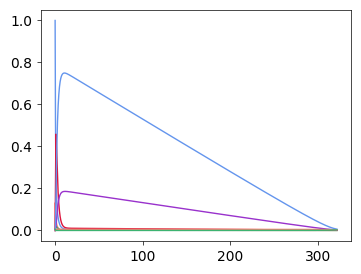

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))
colors = ["C" + str(i) for i in range(7)]
y = scipy_solution.y.T
plt.plot(scipy_solution.t, scipy_solution.y.T, marker="None")
plt.show()

In [7]:
# Some helper functions


def impl_to_method_config(prior, correction, *, label):
    strategy = filters.filter_adaptive(prior, correction)
    return strategy_to_method_config(strategy, label=label)


def strategy_to_method_config(strategy, *, label):
    solver = calibrated.dynamic(strategy)
    return workprecision.MethodConfig(
        method={"solver": solver, "output_scale": 1.0},
        label="ProbDiffEq: " + label,
        key="probdiffeq",
        jit=True,
        plotting_kwargs={"color": "C0"},
    )


def diffrax_method_config(solver, label):
    return workprecision.MethodConfig(
        method={"solver": solver, "max_steps": 10_000},
        label="Diffrax: " + label,
        jit=True,
        key="diffrax",
        plotting_kwargs={"color": "C3"},
    )


def scipy_method_config(method):
    return workprecision.MethodConfig(
        method={"method": method},
        label="SciPy: " + method,
        jit=False,
        key="scipy",
        plotting_kwargs={"color": "C2"},
    )

In [8]:
num_derivatives_low = 3
num_derivatives = 5

prior_low = priors.ibm_adaptive(num_derivatives=num_derivatives_low)
prior = priors.ibm_adaptive(num_derivatives=num_derivatives)

ts1 = corrections.ts1()


# Methods
methods = [
    impl_to_method_config(prior_low, ts1, label=f"DenseTS1({num_derivatives_low})"),
    impl_to_method_config(prior, ts1, label=f"DenseTS1({num_derivatives})"),
    diffrax_method_config(solver=diffrax.Kvaerno3(), label="Kvaerno3()"),
    diffrax_method_config(solver=diffrax.Kvaerno5(), label="Kvaerno5()"),
    scipy_method_config(method="LSODA"),
    scipy_method_config(method="Radau"),
]

In [9]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

TypeError: probdiffeq_terminal_values.<locals>.solve_fn() got an unexpected keyword argument 'output_scale'

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = workprecision.plot(
    results=results,
    fig=fig,
    ax=ax,
    title=problem_config.label,
    xlabel_unit=problem_config.error_unit,
)
plt.show()